# **Import & Install Library**

In [ ]:
#Import library preprocessing
from google.colab import files
import random as rd
import zipfile, os # library untuk mendownload zipfile
from tqdm import tqdm # sebagai pemanis visual saat mengimport gambar ke dalam array list
import numpy as np  # library untuk mengubah gambar menjadi array
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop # mengimport optimizer untuk model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
from keras.utils import to_categorical # Untuk melabeli gambar
import cv2 # Mengimport gambar

#Import library visualisasi
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix # untuk evaluasi model

In [ ]:
# Install library split_folders
pip install split_folders

In [ ]:
# Mendownload data rockpaperscissors menggunakan wget

!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-05-12 11:53:19--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  6.78MB/s    in 44s     

2020-05-12 11:54:04 (6.99 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
# Mengekstrak folder zip yang telah terdownload
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/rockpaperscissors'

Folder yang telah terekstrak akan terlihat seperti ini:
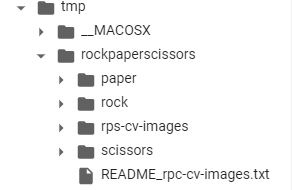

# **Data Preprocessing**

In [ ]:
# Memakai library split_folders untuk membagi data train dan validasi
import split_folders

# Membagi data train dan validasi dengan perbandingan 80% : 20%
split_folders.ratio('/tmp/rockpaperscissors/rps-cv-images', output="dataset", seed=43, ratio=(.8, .2)) 

Copying files: 2188 files [00:01, 1297.55 files/s]


In [ ]:
path = "/content/dataset/"
train_dir = path + "train" 
validation_dir = path + "val"

In [ ]:
print(train_dir)
print(validation_dir)

/content/dataset/train
/content/dataset/val


Splitting akan terlihat seperti gambar di berikut ini:
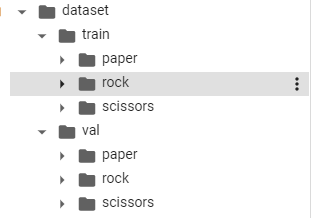

## Memasukkan Data Validasi ke dalam Array List

In [ ]:
print(os.listdir('/tmp/rockpaperscissors/rps-cv-images'))

['scissors', 'README_rpc-cv-images.txt', 'paper', 'rock']


In [ ]:
X = []
Z = []
paper_dir = "/content/dataset/val/paper"
rock_dir = "/content/dataset/val/rock"
scissors_dir = "/content/dataset/val/scissors"

Mendefinisikan Fungsi untuk memasukkan image ke dalam list array

In [ ]:
def assign_label(img, gbk): #gbk gunting batu kertas
    return gbk

def val_data(gbk,DIR): 
    for img in tqdm(os.listdir(DIR)):
        label= assign_label(img, gbk)
        path= os.path.join(DIR,img)
        img= cv2.imread(path,cv2.IMREAD_COLOR)
        img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Warna menjadi RGB
        img= cv2.resize(img, (150,150)) # ukuran gambar menjadi 150 x 150 pixel
        
        X.append(np.array(img))
        Z.append(str(label))
        

Menggabungkan data paper, rock, scissor ke dalam 1 list

In [ ]:
val_data('paper',paper_dir)
print(len(X))

100%|██████████| 143/143 [00:00<00:00, 442.79it/s]

143


In [ ]:
val_data('rock',rock_dir)
print(len(X))

100%|██████████| 146/146 [00:00<00:00, 445.38it/s]

289


In [ ]:
val_data('scissors',scissors_dir)
print(len(X))

100%|██████████| 150/150 [00:00<00:00, 463.01it/s]

439


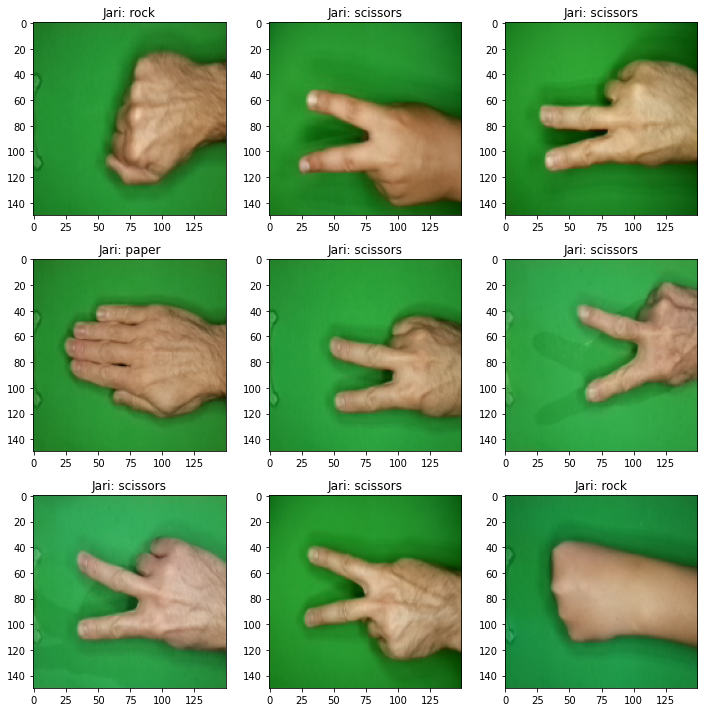

In [ ]:
# Menampilkan gambar validasi dengan acak
fig,ax=plt.subplots(3,3)
fig.set_size_inches(10,10)
for i in range(3):
    for j in range (3):
        gamb=rd.randint(0,len(Z))
        ax[i,j].imshow(X[gamb])
        ax[i,j].set_title('Jari: '+Z[gamb])
        
plt.tight_layout()

## Augmentasi

Melakukan Augmentasi gambar untuk menciptakan data/gambar baru dari data yang telah ada

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range = 0.1, # mengubah zoom image 
                    width_shift_range=0.2,  # mengubah image secara horizontal
                    height_shift_range=0.2)  # mengubah image secara vertikal
                    
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2)
                   

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        class_mode='categorical') # karena ini merupakan masalah klasifikasi lebih dari 2 kelas maka menggunakan class_mode = 'categorical'
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, 
        class_mode='categorical') # karena ini merupakan masalah klasifikasi lebih dari 2 kelas maka menggunakan class_mode = 'categorical'

Found 1749 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


# **Modelling**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='Same', activation='relu',  input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), padding='Same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='Same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), padding='Same', activation='relu'),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.MaxPooling2D(2,2), # mereduksi resolusi gambar
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256, activation='relu'), # Hidden layer
    tf.keras.layers.Dropout(0.1), # agar model tidak overfitting
    
    tf.keras.layers.Dense(256, activation='relu'), # Hidden layer
    tf.keras.layers.Dropout(0.2), 

    tf.keras.layers.Dense(3, activation='softmax') # 3 label output lalu menggunakan softmax karena model adalah klasifikasi kategori
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.RMSprop(learning_rate=0.001), #Menggunakan optimizer rmsprop
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0

In [ ]:
hist=model.fit(
      train_generator,
      steps_per_epoch=90,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=25, # jumlah maksimal epoch yang akan di eksekusi
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=1)


Epoch 1/25
90/90 [==============================] - 27s 304ms/step - loss: 1.1169 - accuracy: 0.3306 - val_loss: 1.1114 - val_accuracy: 0.3000
Epoch 2/25
90/90 [==============================] - 27s 301ms/step - loss: 1.1248 - accuracy: 0.3194 - val_loss: 1.0888 - val_accuracy: 0.3500
Epoch 3/25
90/90 [==============================] - 27s 302ms/step - loss: 1.1205 - accuracy: 0.3583 - val_loss: 1.1754 - val_accuracy: 0.1500
Epoch 4/25
90/90 [==============================] - 27s 305ms/step - loss: 0.9229 - accuracy: 0.5611 - val_loss: 0.7205 - val_accuracy: 0.6500
Epoch 5/25
90/90 [==============================] - 27s 302ms/step - loss: 0.5560 - accuracy: 0.7871 - val_loss: 0.3659 - val_accuracy: 0.8500
Epoch 6/25
90/90 [==============================] - 27s 302ms/step - loss: 0.4079 - accuracy: 0.8556 - val_loss: 0.0855 - val_accuracy: 1.0000
Epoch 7/25
90/90 [==============================] - 28s 306ms/step - loss: 0.4056 - accuracy: 0.8806 - val_loss: 0.0107 - val_accuracy: 1.0000

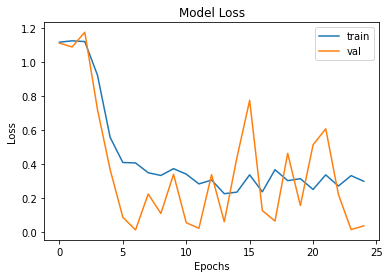

In [ ]:
# Menampilkan plot loss dari model
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

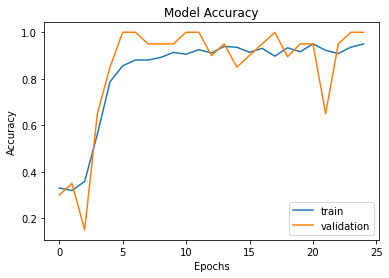

In [ ]:
# Menampilkan plot akurasi dari model
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Melabelkan array yang sudah ada di list array

In [ ]:
# Melabelkan list Y menjadi 3 kategori
le= LabelEncoder()
Y= le.fit_transform(Z)
Y= to_categorical(Y,3)

# Merubah List X menjadi Array lalu menormalisasikannya
X_test= np.array(X)
X_test= X_test/255

Evaluasi Model dengan Confusion Matrix, Precision, Recall & F1-Score

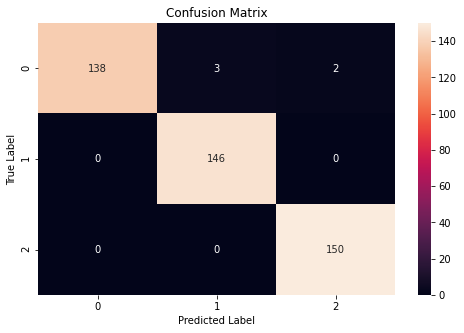

In [ ]:
#Mengevaluasi model dengan confussion matrix

pred= model.predict(X_test)
y_pred= np.argmax(pred, axis=1)
y_true= np.argmax(Y, axis=1)
cm = confusion_matrix(y_true, y_pred)

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Evaluasi model dengan precision, recall & f1-score
from sklearn.metrics import classification_report
print (classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       143
           1       0.98      1.00      0.99       146
           2       0.99      1.00      0.99       150

    accuracy                           0.99       439
   macro avg       0.99      0.99      0.99       439
weighted avg       0.99      0.99      0.99       439



# **Prediksi Model**

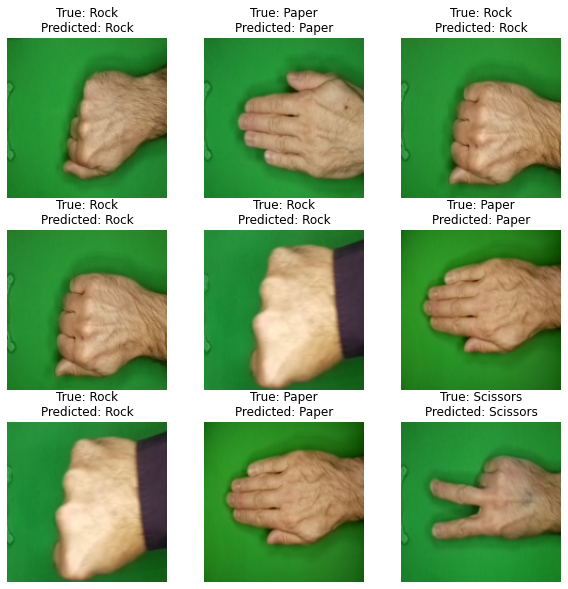

In [ ]:
dict_label = {0:'Paper', 1:'Rock', 2:'Scissors',}
def predict():
  random_data = np.random.randint(low = 0, high = len(X)-1, size=6)
  sample_images = X_test[random_data]
  sample_label = Y[random_data]
  predicted = model.predict(sample_images)
  predicted = np.argmax(predicted, axis=1) # Mengembalikan nilai terbesar dari array prediksi
  true_label = np.argmax(sample_label, axis=1) # Mengembalikan nilai terbesar dari array sample_label
  fig, axs = plt.subplots(3, 3)
  fig.set_size_inches(10,10)
  for row in range(3):
    for col in range(3):
      if row == 0:
        true = true_label[row+col]
        pred = predicted[row+col]
        axs[row, col].imshow(sample_images[row+col])
      else:
        true = true_label[row+col+1]
        pred = predicted[row+col+1]
        axs[row, col].imshow(sample_images[row+col+1])
      axs[row, col].set_title('True: %s\nPredicted: %s' % (dict_label[true], dict_label[pred]))
      axs[row, col].axis('off')

predict()

Saving 3XEQ73XMn7zaww2T.png to 3XEQ73XMn7zaww2T.png
[0]
paper


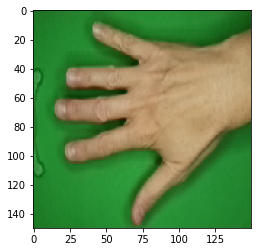

In [ ]:
# Mengupload dan memprediksi gambar baru yang telah diupload
# Apabila run pertama error maka harus dirun 2x
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # memprediksi gambar
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  pred = model.predict(images, batch_size=10)
  classes = np.argmax(pred,axis=1)
  
  print(classes)
  if classes == 0:
      print('paper')
  elif classes == 1:
      print('rock')
  else :
      print('scissors')
  

https://colab.research.google.com/drive/1YJ4yKONgol0fxQbyKp3xYrH_uUbyOJti?usp=sharing #Live view from colab